You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [28]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

import itertools

%matplotlib inline

In [2]:
df=pd.read_csv('results.csv')

In [3]:
pd.set_option('display.expand_frame_repr', False)
from IPython.display import display
pd.options.display.max_columns=None
df=df.reindex(sorted(df.columns),axis=1)
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
0,17.37,37.65,47.67,59.18,71.40,80.43,8.02,47,W1,Fukuoka,JPN,NaN,8,M,8,39.72,"Yamamoto, Hiroyuki",85.25,8,3.27,NaN
1,32.58,65.83,82.43,99.33,116.37,132.10,16.22,33,F1,Eldoret,KEN,NaN,1,F,1,69.47,"Jeptoo, Rita",138.95,21,5.30,NaN
2,16.62,36.10,45.80,56.45,67.42,76.10,7.75,41,W2,Paarl,RSA,NaN,1,M,1,38.03,"Van Dyk, Ernst F.",80.60,1,3.08,NaN
3,32.57,65.83,82.43,99.33,116.37,132.95,16.20,24,F2,Shoa,ETH,NaN,3,F,3,69.47,"Dibaba, Mare",140.58,27,5.37,NaN
4,17.12,36.58,46.37,57.03,67.83,76.72,8.02,40,W3,Nogata Fukuoka,JPN,NaN,2,M,2,38.60,"Hokinoue, Kota",81.23,2,3.10,NaN


In [4]:
df.dtypes

10k           object
20k           object
25k           object
30k           object
35k           object
40k           object
5k            object
age            int64
bib           object
city          object
country       object
ctz           object
division       int64
gender        object
genderdiv      int64
half          object
name          object
official     float64
overall        int64
pace         float64
state         object
dtype: object

In [5]:
X=df.iloc[:,:7]

In [6]:
df.shape

(31984, 21)

## Features Selection

In [7]:
col=X.columns.values
col

array(['10k', '20k', '25k', '30k', '35k', '40k', '5k'], dtype=object)

## Data Cleaning

In [8]:
col=X.columns.values
for i in col:
    df.drop(df[df[i]=='-'].index,inplace=True)
    df[i]=df[i].astype(float)

In [9]:
df.shape

(31687, 21)

In [10]:
df.dtypes

10k          float64
20k          float64
25k          float64
30k          float64
35k          float64
40k          float64
5k           float64
age            int64
bib           object
city          object
country       object
ctz           object
division       int64
gender        object
genderdiv      int64
half          object
name          object
official     float64
overall        int64
pace         float64
state         object
dtype: object

In [11]:
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
0,17.37,37.65,47.67,59.18,71.40,80.43,8.02,47,W1,Fukuoka,JPN,NaN,8,M,8,39.72,"Yamamoto, Hiroyuki",85.25,8,3.27,NaN
1,32.58,65.83,82.43,99.33,116.37,132.10,16.22,33,F1,Eldoret,KEN,NaN,1,F,1,69.47,"Jeptoo, Rita",138.95,21,5.30,NaN
2,16.62,36.10,45.80,56.45,67.42,76.10,7.75,41,W2,Paarl,RSA,NaN,1,M,1,38.03,"Van Dyk, Ernst F.",80.60,1,3.08,NaN
3,32.57,65.83,82.43,99.33,116.37,132.95,16.20,24,F2,Shoa,ETH,NaN,3,F,3,69.47,"Dibaba, Mare",140.58,27,5.37,NaN
4,17.12,36.58,46.37,57.03,67.83,76.72,8.02,40,W3,Nogata Fukuoka,JPN,NaN,2,M,2,38.60,"Hokinoue, Kota",81.23,2,3.10,NaN


## Shuffle

In [12]:
from sklearn.utils import shuffle
df = shuffle(df)

In [13]:
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
15836,52.82,105.50,132.08,158.75,185.38,211.20,26.47,39,18104,Baileys Harbor,USA,NaN,2719,F,4033,111.25,"Lawell, Krista N.",222.13,13060,8.48,WI
29240,69.92,136.77,175.53,219.27,260.57,302.20,36.63,23,32847,Brookline,USA,NaN,6114,F,12648,143.95,"Wetzel, Liza J",318.78,28767,12.17,MA
31250,48.48,98.65,124.10,151.33,180.33,216.47,23.68,48,35125,Leiderdorp,NED,NaN,1912,M,10083,104.17,"Koeleman, Wim",231.02,15572,8.82,NaN
79,25.28,57.05,73.00,93.67,114.77,127.60,11.73,32,W35,Park City,USA,NaN,36,M,38,59.95,"Hulin, Ben R.",134.73,47,5.15,UT
3736,41.33,82.33,103.00,123.92,144.70,165.30,20.80,37,4238,Omaha,USA,NaN,1009,M,1302,86.85,"Polking, Ross",174.17,1376,6.65,NE


## Reset dataframe Index

In [14]:
df=df.reset_index(drop=True)

In [15]:
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
0,52.82,105.50,132.08,158.75,185.38,211.20,26.47,39,18104,Baileys Harbor,USA,NaN,2719,F,4033,111.25,"Lawell, Krista N.",222.13,13060,8.48,WI
1,69.92,136.77,175.53,219.27,260.57,302.20,36.63,23,32847,Brookline,USA,NaN,6114,F,12648,143.95,"Wetzel, Liza J",318.78,28767,12.17,MA
2,48.48,98.65,124.10,151.33,180.33,216.47,23.68,48,35125,Leiderdorp,NED,NaN,1912,M,10083,104.17,"Koeleman, Wim",231.02,15572,8.82,NaN
3,25.28,57.05,73.00,93.67,114.77,127.60,11.73,32,W35,Park City,USA,NaN,36,M,38,59.95,"Hulin, Ben R.",134.73,47,5.15,UT
4,41.33,82.33,103.00,123.92,144.70,165.30,20.80,37,4238,Omaha,USA,NaN,1009,M,1302,86.85,"Polking, Ross",174.17,1376,6.65,NE


## Deivide dataset to 4 evenly sized subset

In [16]:
rows=df.shape[0]-df.shape[0]%4
df=df.iloc[:rows,:8]
df.head()

,10k,20k,25k,30k,35k,40k,5k,age
0,52.82,105.50,132.08,158.75,185.38,211.20,26.47,39
1,69.92,136.77,175.53,219.27,260.57,302.20,36.63,23
2,48.48,98.65,124.10,151.33,180.33,216.47,23.68,48
3,25.28,57.05,73.00,93.67,114.77,127.60,11.73,32
4,41.33,82.33,103.00,123.92,144.70,165.30,20.80,37


In [17]:
df.shape

(31684, 8)

In [18]:
df=np.split(df,4,axis=0)

In [19]:
df[0]

,10k,20k,25k,30k,35k,40k,5k,age
0,52.82,105.50,132.08,158.75,185.38,211.20,26.47,39
1,69.92,136.77,175.53,219.27,260.57,302.20,36.63,23
2,48.48,98.65,124.10,151.33,180.33,216.47,23.68,48
3,25.28,57.05,73.00,93.67,114.77,127.60,11.73,32
4,41.33,82.33,103.00,123.92,144.70,165.30,20.80,37
5,44.65,90.87,114.87,138.97,164.12,188.95,21.92,35
6,52.63,106.17,133.65,162.10,194.98,235.82,26.32,59
7,49.50,99.57,125.27,150.98,177.02,202.37,24.45,57
8,50.73,112.30,154.48,198.13,248.40,293.03,24.38,30
9,35.72,73.00,93.03,115.05,137.22,159.65,17.80,38


## Features Selection

In [20]:
df[0].iloc[:rows,:7]

,10k,20k,25k,30k,35k,40k,5k
0,52.82,105.50,132.08,158.75,185.38,211.20,26.47
1,69.92,136.77,175.53,219.27,260.57,302.20,36.63
2,48.48,98.65,124.10,151.33,180.33,216.47,23.68
3,25.28,57.05,73.00,93.67,114.77,127.60,11.73
4,41.33,82.33,103.00,123.92,144.70,165.30,20.80
5,44.65,90.87,114.87,138.97,164.12,188.95,21.92
6,52.63,106.17,133.65,162.10,194.98,235.82,26.32
7,49.50,99.57,125.27,150.98,177.02,202.37,24.45
8,50.73,112.30,154.48,198.13,248.40,293.03,24.38
9,35.72,73.00,93.03,115.05,137.22,159.65,17.80


## Create Empty List

In [21]:
features=[]
target=[]

In [22]:
for i in range(0,4):
    features.append(df[i].iloc[:rows,:7])
    target.append(df[i].iloc[:rows,7])

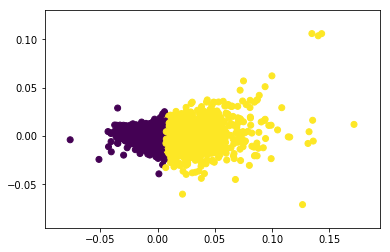

col_0     0     1
row_0            
0      2807  2712
1      1106  1296
0.0011657631999919434


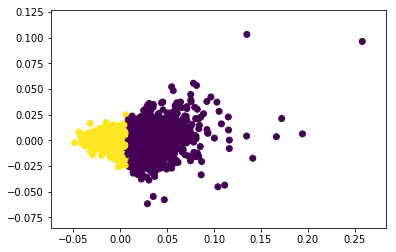

col_0     0     1
row_0            
0      1159  1219
1      2900  2643
0.0013971090073706324


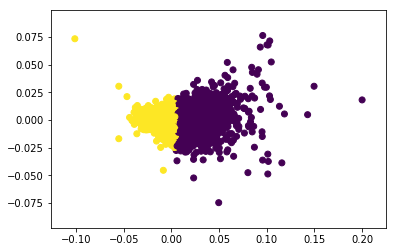

col_0     0     1
row_0            
0      1200  1359
1      2727  2635
0.0008848268121064223


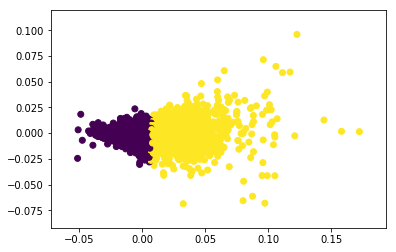

col_0     0     1
row_0            
0      2836  2681
1      1170  1234
0.0006373619819244126


In [23]:
for i in range(0,4):
    X_norm=normalize(features[i])
    X_pca=PCA(2).fit_transform(X_norm)
    y=np.where(target[i]>42,1,0)

    y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
    plt.show()

    table=pd.crosstab(y_pred,y)
    print(table)

    score=metrics.adjusted_rand_score(y,y_pred)
    print(score)

## Adjusted Rand Score

In [24]:
for i in range(0,4):
    X_norm=normalize(features[i])
    X_pca=PCA(2).fit_transform(X_norm)
    y=np.where(target[i]>42,1,0)

    y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_norm)

    #plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
    #plt.show()

    table=pd.crosstab(y_pred,y)
    print(table)

    score=metrics.adjusted_rand_score(y,y_pred)
    print(score)
    print()

col_0     0     1
row_0            
0      2806  2709
1      1107  1299
0.0012023760416274337

col_0     0     1
row_0            
0      1170  1223
1      2889  2639
0.0012602184590487023

col_0     0     1
row_0            
0      2726  2637
1      1201  1357
0.0008373987606633564

col_0     0     1
row_0            
0      2840  2684
1      1166  1231
0.0006513814180389897



## Silhouette Coefficient

In [25]:
for n in range(2,3):
    print()
    print("Number of Clusters: ",n)
    for i in range(0,4):
        X_norm=normalize(features[i])
        y=np.where(target[i]>42,1,0)

        model = KMeans(n_clusters=n, random_state=42).fit(X_norm)
        labels=model.labels_
      
        score=metrics.silhouette_score(X_norm, labels, metric='euclidean')
        print(score)
        


Number of Clusters:  2
0.5199145989217151
0.5234275578768965
0.5177587005170063
0.5281457166222338


## Mean-Shift

In [26]:
for i in range(0,4):
    X_norm=normalize(features[i])
    X_pca=PCA(2).fit_transform(X_norm)
    y=np.where(target[i]>42,1,0)

    bw=estimate_bandwidth(X_norm,quantile=0.2)

    mode=MeanShift(bandwidth=bw,bin_seeding=True)
    model.fit(X_norm)
    
    labels=model.labels_
    
    n_clusters=len(np.unique(labels))

    print("Number of Clusters: ",n_clusters)
    
    score=metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print(score)
    print()

Number of Clusters:  2
0.5199145989217151

Number of Clusters:  2
0.5234275578768965

Number of Clusters:  2
0.5177587005170063

Number of Clusters:  2
0.5281457166222338



## Spectral Clustering

In [30]:
for n in range(2,6):
    print()
    print("Number of Clusters: ",n)
    for i in range(0,4):
        X_norm=normalize(features[i])
        y=np.where(target[i]>42,1,0)

        model = SpectralClustering(n_clusters=n, random_state=42).fit(X_norm)
        labels=model.labels_
      
        score=metrics.silhouette_score(X_norm, labels, metric='euclidean')
        print(score)


Number of Clusters:  2
0.5198964524363394
0.5242200526746984
0.519780843358993
0.530149605420985

Number of Clusters:  3
0.430547455102409
0.42856987680477915
0.41990462505946635
0.4367420544905895

Number of Clusters:  4
0.3829443298245567
0.38092597331563854
0.36887917202286846
0.37974686466125857

Number of Clusters:  5
0.31743658817577014
0.3080209097410139
0.3165625900022866
0.3373284414306421


## Affinity Propagation

In [32]:
for i in range(0,4):
    X_norm=normalize(features[i])
    X_pca=PCA(2).fit_transform(X_norm)
    y=np.where(target[i]>42,1,0)

    model=AffinityPropagation()
    model.fit(X_norm)
    
    labels=model.labels_
    
    cluster_centers_indices=model.cluster_centers_indices_
    n_clusters=len(cluster_centers_indices)

    print("Number of Clusters: ",n_clusters)
    
    score=metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print(score)
    print()

Number of Clusters:  177
0.14984936895135667

Number of Clusters:  179
0.15053258857847862

Number of Clusters:  176
0.1574181248044198

Number of Clusters:  180
0.15777028515125877

